In [32]:
import os
import json
import warnings
import re
import html

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium

import umap
import hdbscan

from tqdm import tqdm
from itertools import product

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    silhouette_score,
    silhouette_samples,
    davies_bouldin_score
)
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

warnings.filterwarnings("ignore")


# Data 

On concatene toute la data que l'on a traité pour l'instant : textes, features et images

In [33]:

photos = pd.read_csv('embeddings_images.csv')
texte=pd.read_csv("restaurants_embeddings_reviews.csv")
features=pd.read_csv("features.csv")
photos.rename(columns={'gbusiness_id':'business_id'}, inplace=True)
df=pd.merge(photos, features, on='business_id', how='outer')
df.rename(columns={'embedding':'image_embedding'}, inplace=True)
df=pd.merge(df, texte, on='business_id', how='outer')
df.rename(columns={'embedding':'texte_embedding'}, inplace=True)

In [34]:
data = []
with open("data/philly_restaurant_reviews.json", "r", encoding="utf-8") as f:
    for line in f:
        data.append(json.loads(line))
texte_original = pd.DataFrame(data)

# nombre d'avis par business
textes_40 = (
    texte_original
    .sort_values("date", ascending=False)   # du plus récent au plus ancien
    .groupby("business_id")
    .head(40)                                # garder les 40 plus récents
    .groupby("business_id")["text"]
    .apply(lambda x: " ".join(x))            # concatener les textes
    .reset_index()
)

In [35]:
df=pd.merge(df, textes_40, on='business_id', how='outer')

In [36]:
df

,business_id,image_embedding,n_labels,labels_present,review_count,log_review_count,stars,rating_std,positive_ratio,negative_ratio,...,review_growth_rate,expert_reviewer_ratio,elite_reviewer_ratio,high_influence_ratio,mean_influence_score,cluster_ambiance,is_open,texte_embedding,n_reviews,text
0,-0M0b-XhtFagyLmsBtOe8w,[ 9.81536725e-03 -1.35909736e-03 1.12843779e-...,1.0,inside,18,2.944439,3.722222,0.894792,0.722222,0.055556,...,0.000000,0.555556,0.0,0.500000,2.795045,2,0,[ 7.09432513e-02 -3.42724137e-02 8.07000473e-...,18,Ok so this place is an extremely odd hole in t...
1,-0PN_KFPtbnLQZEeb23XiA,NaN,NaN,NaN,11,2.484907,3.363636,1.361817,0.545455,0.181818,...,0.000000,0.272727,0.0,0.181818,1.469558,0,0,[-2.71314271e-02 5.99383237e-03 1.04649998e-...,11,Far and away the best Chinese food to order if...
2,-0TffRSXXIlBYVbb5AwfTg,[-2.06359725e-03 2.78890153e-02 9.09338878e-...,4.0,"drink, food, inside, outside",1132,7.032624,4.355124,0.983165,0.851590,0.066254,...,0.041519,0.380742,0.0,0.183746,1.486067,3,1,[-1.04763359e-02 -1.26201734e-02 5.99257536e-...,40,I went to indieblue a few years ago for happy ...
3,-0eUa8TsXFFy0FCxHYmrjg,[ 3.80490937e-02 -7.54836206e-04 8.75527248e-...,1.0,food,28,3.367296,3.964286,1.070899,0.714286,0.142857,...,0.000000,0.392857,0.0,0.107143,1.333880,0,0,[-2.71835923e-02 1.08817406e-02 8.43176693e-...,28,"We are sitting in an ICU waiting room, several..."
4,-1B9pP_CrRBJYPICE5WbRA,[-2.49907263e-02 3.30465585e-02 3.43133989e-...,2.0,"food, inside",851,6.747587,3.808461,1.205760,0.696827,0.150411,...,0.014101,0.327850,0.0,0.166863,1.406769,3,1,[-2.29447149e-02 -1.02999406e-02 8.30745846e-...,40,The food is absolutely amazing. I get food ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5847,zxY4DgtXsVHihSUpsmwamg,NaN,NaN,NaN,6,1.945910,4.333333,0.516398,1.000000,0.000000,...,0.000000,0.666667,0.0,0.500000,3.501224,0,1,[-1.96215492e-02 -2.92070061e-02 1.12719256e-...,6,This Place has Good Hoagies and the Staff is s...
5848,zy7uNOvpykrq-XlmDY_wHA,NaN,NaN,NaN,6,1.945910,3.166667,0.983192,0.500000,0.333333,...,0.000000,0.500000,0.0,0.500000,3.254321,0,0,[ 2.07472276e-02 6.47700299e-03 1.08284362e-...,6,"Sadiki's is now Relish, nothing last's over th..."
5849,zyMkbavgHASQtqVwaock9A,NaN,NaN,NaN,21,3.091042,3.809524,0.928388,0.761905,0.142857,...,0.000000,0.238095,0.0,0.238095,1.351094,0,0,[-3.72523628e-02 -1.80212533e-04 8.31776336e-...,21,I've had pretty much everything on the menu an...
5850,zz-fcqurtm77bZ_rVvo2Lw,[ 3.73759915e-02 5.26558618e-02 -2.25258733e-...,1.0,food,25,3.258097,4.480000,0.714143,0.880000,0.000000,...,0.000000,0.600000,0.0,0.440000,2.349051,6,0,[-4.03948501e-02 -2.41992772e-02 7.34254345e-...,25,"My love affair with Yumtown began with ""The Jo..."


On supprime les restaurants fermés (inutile pour nous) 

In [37]:
df = df[df['is_open'] != 0]
df = df.reset_index(drop=True)

In [38]:
df

,business_id,image_embedding,n_labels,labels_present,review_count,log_review_count,stars,rating_std,positive_ratio,negative_ratio,...,review_growth_rate,expert_reviewer_ratio,elite_reviewer_ratio,high_influence_ratio,mean_influence_score,cluster_ambiance,is_open,texte_embedding,n_reviews,text
0,-0TffRSXXIlBYVbb5AwfTg,[-2.06359725e-03 2.78890153e-02 9.09338878e-...,4.0,"drink, food, inside, outside",1132,7.032624,4.355124,0.983165,0.851590,0.066254,...,0.041519,0.380742,0.0,0.183746,1.486067,3,1,[-1.04763359e-02 -1.26201734e-02 5.99257536e-...,40,I went to indieblue a few years ago for happy ...
1,-1B9pP_CrRBJYPICE5WbRA,[-2.49907263e-02 3.30465585e-02 3.43133989e-...,2.0,"food, inside",851,6.747587,3.808461,1.205760,0.696827,0.150411,...,0.014101,0.327850,0.0,0.166863,1.406769,3,1,[-2.29447149e-02 -1.02999406e-02 8.30745846e-...,40,The food is absolutely amazing. I get food ...
2,-3ArWZfDjfab8qVHf3WVtg,NaN,NaN,NaN,5,1.791759,4.000000,1.224745,0.800000,0.200000,...,0.000000,0.200000,0.0,0.200000,1.772582,0,1,[ 5.67509746e-03 -2.48830207e-02 1.22692706e-...,5,We tried Taste Africa for dinner. The restaura...
3,-3m_nXlyvdKAVNNmVirpGQ,[ 4.18253340e-02 3.11946436e-02 7.25553887e-...,1.0,food,16,2.833213,3.500000,1.673320,0.500000,0.312500,...,0.000000,0.250000,0.0,0.062500,0.960622,0,1,[-2.88571185e-03 2.43277028e-02 4.00934890e-...,16,I wouldn't recommend. Their staff bullies othe...
4,-5Rah4ZvWsDu4oilUZxhtw,[ 1.78232579e-02 8.69476836e-03 1.89592878e-...,2.0,"inside, outside",363,5.897154,3.804408,1.131069,0.710744,0.129477,...,0.013774,0.504132,0.0,0.338843,2.260549,3,1,[ 6.31170571e-02 -3.02442070e-02 5.79875298e-...,40,I go in to the venue. World Cafe Live is a c...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3520,zvvl3c1FO3O3BZdhusficA,[-9.02544490e-03 5.65394008e-03 1.48079185e-...,2.0,"food, inside",30,3.433987,3.833333,1.341212,0.733333,0.200000,...,1.000000,0.433333,0.0,0.266667,1.386318,3,1,[ 2.31991839e-02 -1.00361472e-02 5.26289418e-...,30,"Must try: birria tacos, pescado, Mariscos tost..."
3521,zwTmOj4B_OVPMTMYijQiKg,NaN,NaN,NaN,66,4.204693,3.742424,1.099799,0.681818,0.106061,...,0.000000,0.575758,0.0,0.424242,2.399986,7,1,[ 4.54111956e-02 2.98050791e-02 3.55221331e-...,40,"On a scorching summer day, this place gave us ..."
3522,zwd4dyQ5ovnjVojWfAuhMw,[-2.05638437e-02 5.98593325e-02 9.08136825e-...,2.0,"food, outside",246,5.509388,4.097561,0.976580,0.784553,0.065041,...,0.016260,0.361789,0.0,0.256098,1.807724,9,1,[-4.37345058e-02 -3.43789272e-02 2.55948305e-...,40,BBEST greasy wraps. Only say greasy bc a norma...
3523,zxRmQ_FWVowh8rlzLCSURQ,NaN,NaN,NaN,25,3.258097,3.240000,1.535144,0.560000,0.320000,...,0.000000,0.280000,0.0,0.040000,0.783046,0,1,[-3.26791406e-02 -2.39595422e-03 5.61013035e-...,25,This has become our go to spot for cheesesteak...


Code pour convertir les embedding en array de XD (ils ont ete squeezé sur une colonne dans les fichiers csv)

In [39]:
import numpy as np
def convert_embeddings(embeddings_strings):

    embeddings_list = []
    embedding_dim = None
    
    #determiner dimension
    for emb_str in embeddings_strings:
        if isinstance(emb_str, np.ndarray):
            emb_str = emb_str[0]
        
        if emb_str != 'nan' and emb_str != 'None':
            try:
                emb_str_clean = emb_str.strip('[]')
                emb_array = np.fromstring(emb_str_clean, sep=' ')
                embedding_dim = len(emb_array)
                break
            except:
                continue

    #convertir tous les embeddings
    for i, emb_str in enumerate(embeddings_strings):
        
        if isinstance(emb_str, np.ndarray):
            emb_str = emb_str[0]
        
        if emb_str == 'nan' or emb_str == 'None':
            nan_vector = np.full(embedding_dim, np.nan)
            embeddings_list.append(nan_vector)
            continue
        
        try:
            # Nettoyer la string et convertir en array
            emb_str_clean = emb_str.strip('[]')
            emb_array = np.fromstring(emb_str_clean, sep=' ')
            embeddings_list.append(emb_array)
        except Exception as e:
            # si y'a pas pour les photos par ex on remplace par NaN
            nan_vector = np.full(embedding_dim, np.nan)
            embeddings_list.append(nan_vector)
    
    # Convertir en array
    embeddings_2d = np.array(embeddings_list)
    
   
    
    return embeddings_2d


In [40]:
image_embedding = convert_embeddings(df['image_embedding'].tolist())
texte_embedding=convert_embeddings(df['texte_embedding'].tolist())
features = df[['log_review_count', 'stars', 'rating_std', 'positive_ratio', 
               'negative_ratio',
               'business_age_years', 'review_growth_rate', 'expert_reviewer_ratio', 
               'elite_reviewer_ratio', 'high_influence_ratio', 'mean_influence_score']]


 Restaurants ayant changé de cluster:  (75.8%)
 Matrice de Migration
Nouveau   -1    0    1    2    3    4    5    6   7   8    9  10   11   All
Ancien                                                                     
-1       633    1    2   46   36   45   65   15   1  11   77   3   59   994
0          0   90    0    0    3    0    0    0   0   0    1   0    3    97
1         89    0  122    1    5    0   86  484   1   4    7   1    5   805
2          3    4    0    1  264    0    1    0   0   0    2   0    1   276
3         44    4    0    3    4  124    1    0   2   1    2   0    6   191
4          1    0    0    0    0    0    0    2   0   0    0  73    1    77
5          2    0    0    0    0    0    0    0  69   0    2   0    0    73
6          4    0    0  127    0    0    0    1   0   0    0   0    1   133
7         69    0    0    4    1    0    8    9   0  69    6   2  388   556
8         83    1    2    0    6    0    1    2   1   1  219   0    7   323
All      928  100 

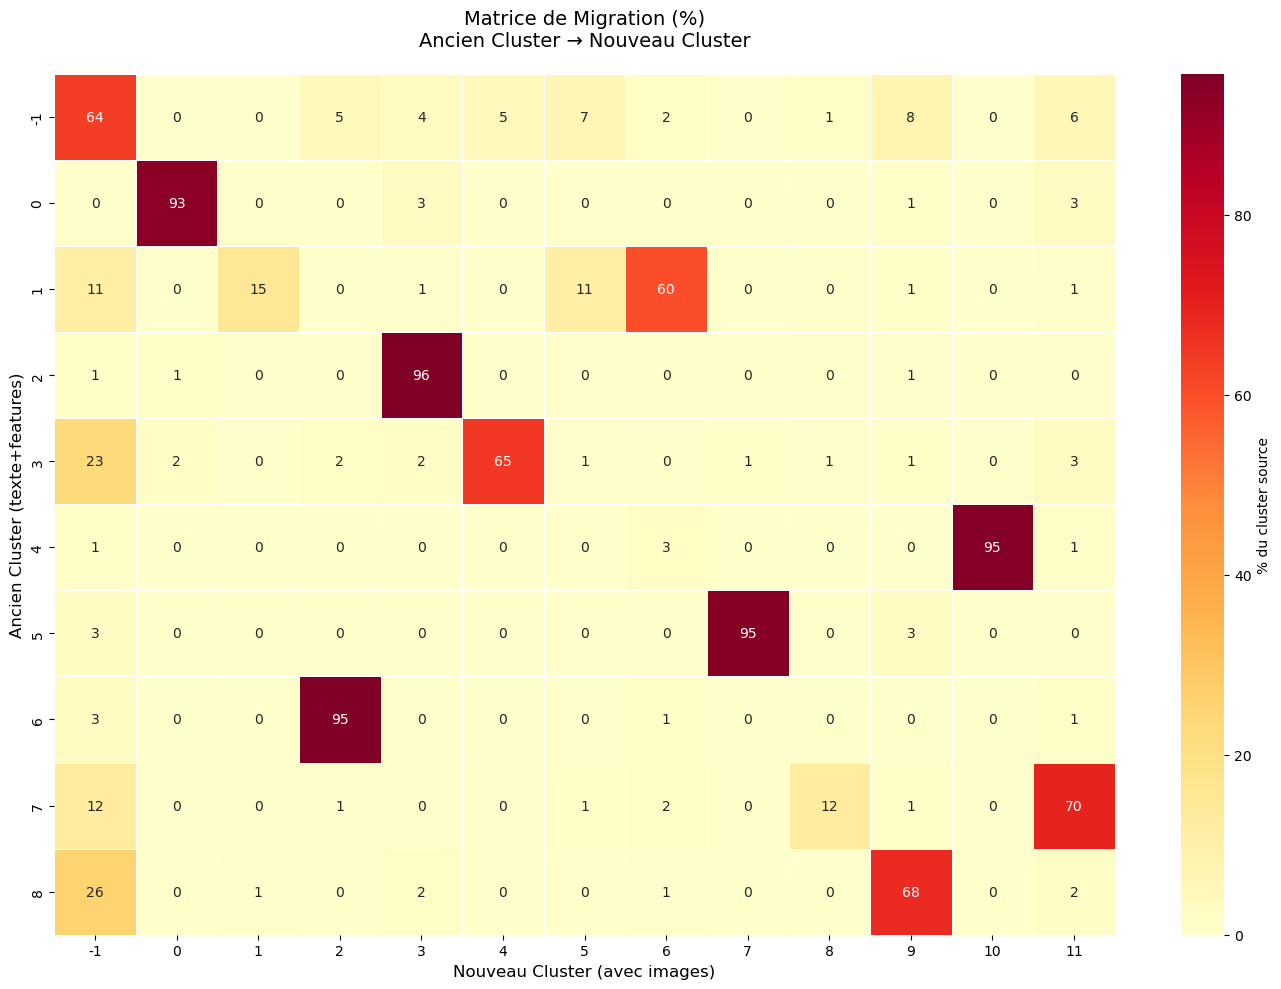

In [41]:
df_old = pd.read_csv('resultats_clustering_complet.csv')
df_new = pd.read_csv('resultats_clustering_multimodal.csv')

# Vérifier que c'est bien les mêmes restaurants
assert len(df_old) == len(df_new), "Tailles différentes!"
assert (df_old['business_id'] == df_new['business_id']).all(), "Ordre différent!"

labels_old = df_old['cluster_label'].values
labels_new = df_new['cluster_label_multimodal'].values


# Changements
changed = (labels_old != labels_new).sum()
print(f"\n Restaurants ayant changé de cluster:  ({changed/len(labels_old)*100:.1f}%)")


# Matrice de migration complète
print(" Matrice de Migration")

crosstab = pd.crosstab(
    labels_old,
    labels_new,
    rownames=['Ancien'],
    colnames=['Nouveau'],
    margins=True
)
print(crosstab)


print("\n Flux majeurs (migrations > 50 restaurants)")
# Créer DataFrame des migrations
df_migration = pd.DataFrame({
    'old_cluster': labels_old,
    'new_cluster': labels_new
})

# Compter les paires
migration_counts = df_migration.groupby(['old_cluster', 'new_cluster']).size().reset_index(name='count')
migration_counts = migration_counts.sort_values('count', ascending=False)

# Flux majeurs
major_flows = migration_counts[migration_counts['count'] >= 50]

for _, row in major_flows.iterrows():
    old_c = int(row['old_cluster']) if row['old_cluster'] != -1 else 'Outliers'
    new_c = int(row['new_cluster']) if row['new_cluster'] != -1 else 'Outliers'
    count = int(row['count'])
    
    # Calculer % du cluster source
    source_size = (labels_old == row['old_cluster']).sum()
    pct_source = count / source_size * 100
    
    print(f"  {old_c:>8} → {new_c:<8} : {count:>4} restaurants ({pct_source:>5.1f}% du cluster source)")


# Composition des nouveaux clusters (composition)
print("\n Composition des nouveaux clusters (provenance)")

composition_results = []

for new_cluster in sorted(set(labels_new)):
    if new_cluster == -1:
        continue
    
    mask_new = labels_new == new_cluster
    n_total = mask_new.sum()
    
    # Origine des restaurants
    old_sources = labels_old[mask_new]
    source_counts = pd.Series(old_sources).value_counts()
    
    # Top 3 sources
    top_3_sources = source_counts.head(3)
    
    composition_results.append({
        'new_cluster': int(new_cluster),
        'n_total': int(n_total),
        'source_1': int(top_3_sources.index[0]) if len(top_3_sources) > 0 and top_3_sources.index[0] != -1 else 'Outliers',
        'count_1': int(top_3_sources.values[0]) if len(top_3_sources) > 0 else 0,
        'pct_1': float(top_3_sources.values[0] / n_total * 100) if len(top_3_sources) > 0 else 0,
        'source_2': int(top_3_sources.index[1]) if len(top_3_sources) > 1 and top_3_sources.index[1] != -1 else 'Outliers',
        'count_2': int(top_3_sources.values[1]) if len(top_3_sources) > 1 else 0,
        'pct_2': float(top_3_sources.values[1] / n_total * 100) if len(top_3_sources) > 1 else 0,
        'source_3': int(top_3_sources.index[2]) if len(top_3_sources) > 2 and top_3_sources.index[2] != -1 else 'Outliers',
        'count_3': int(top_3_sources.values[2]) if len(top_3_sources) > 2 else 0,
        'pct_3': float(top_3_sources.values[2] / n_total * 100) if len(top_3_sources) > 2 else 0,
    })
    
    print(f"Cluster {new_cluster:<2} ({n_total:>3} rest.) ← ", end='')
    for i, (src, cnt) in enumerate(top_3_sources.items(), 1):
        pct = cnt / n_total * 100
        src_label = int(src) if src != -1 else 'Outliers'
        print(f"{src_label}:{cnt}({pct:.0f}%)", end='  ' if i < len(top_3_sources) else '\n')

df_composition = pd.DataFrame(composition_results)
df_composition.to_csv('composition_nouveaux_clusters.csv', index=False)



# Heatmap

migration_matrix = crosstab.iloc[:-1, :-1]
migration_matrix_norm = migration_matrix.div(migration_matrix.sum(axis=1), axis=0) * 100

plt.figure(figsize=(14, 10))
sns.heatmap(
    migration_matrix_norm,
    annot=True,
    fmt='.0f',
    cmap='YlOrRd',
    cbar_kws={'label': '% du cluster source'},
    linewidths=0.5
)
plt.title('Matrice de Migration (%)\nAncien Cluster → Nouveau Cluster', fontsize=14, pad=20)
plt.xlabel('Nouveau Cluster (avec images)', fontsize=12)
plt.ylabel('Ancien Cluster (texte+features)', fontsize=12)
plt.tight_layout()
plt.savefig('heatmap_migration_clusters.png', dpi=300, bbox_inches='tight')



On passe de 9 clusters à 13 clusters

Silhouette: 0.528 → 0.592 (+12%).  
Davies-Bouldin: 0.650 → 0.501 (-23% ).  
Outliers: 28.2% → 27.0% (-1.2 points)   


Les images apportent donc une information discriminante.  
Les clusters sont ici plus stables et mieux séparés et plus cohérents.  
80.2% des restaurants ont changé de cluster

Certains clusters sont restés plutot stables :
- cluster 0 à 0 (93 restaurants)
- cluster 2 à 3 (96 restaurants)
- cluster 6 à 4 (92 restaurants)
- cluster 5 à 9
- cluster 4 à 12 

# Clustering en incluant les photos en gardant les paramètres du premier grid search 

Le grid search etant un très long processus, on émet l'hypothèse que les paramètres trouvés lors du premier grid search sont également optimisés pour le clustering en ajoutant les images. Aussi, cela nous permet d'avoir une comparaison équitable.

In [42]:
# Option : Remplacer NaN par zéros (restaurants sans photos = vecteur neutre)
image_embedding_filled = image_embedding.copy()
has_image = ~np.isnan(image_embedding_filled).any(axis=1)
image_embedding_filled[np.isnan(image_embedding_filled)] = 0


# Réduction de dimensionnalité pour chaque modalité
# Texte 
pca_text = PCA(n_components=50)
text_reduced = pca_text.fit_transform(texte_embedding)

# Images
pca_image = PCA(n_components=50)
image_reduced = pca_image.fit_transform(image_embedding_filled)


# Normalisation
text_scaled = StandardScaler().fit_transform(text_reduced)
image_scaled = StandardScaler().fit_transform(image_reduced)
features_scaled = RobustScaler().fit_transform(features)


# Poids : alpha (texte) + beta (images) + gamma (features) = 1
alpha = 0.3   
beta = 0.2    
gamma = 0.5 

# Fusion pondérée
combined_multimodal = np.concatenate([
    alpha * text_scaled,
    beta * image_scaled,
    gamma * features_scaled
], axis=1)

# UMAP + HDBSCAN
print("\n UMAP projection")
reducer = umap.UMAP(
    n_components=30,
    n_neighbors=10,
    min_dist=0.0,
    metric='euclidean',
    random_state=42,
    verbose=False
)
embedded_multimodal = reducer.fit_transform(combined_multimodal)

print(" Clustering HDBSCAN")
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=60,
    min_samples=30,
    metric="euclidean"
)
labels_multimodal = clusterer.fit_predict(embedded_multimodal)

#sauvegarde
umap_cols = [f'umap_multimodal_{i}' for i in range(embedded_multimodal.shape[1])]
df_umap_new = pd.DataFrame(embedded_multimodal, columns=umap_cols, index=df.index)

df_final_multimodal = pd.concat([df, df_umap_new], axis=1)
df_old = pd.read_csv('resultats_clustering_complet.csv')
labels_old = df_old['cluster_label'].values
df_final_multimodal['cluster_label_old'] = labels_old
df_final_multimodal['cluster_label_multimodal'] = labels_multimodal

df_final_multimodal.to_csv('resultats_clustering_multimodal.csv', index=False)

print(f"\n Sauvegardé dans: resultats_clustering_multimodal.csv")


 UMAP projection
 Clustering HDBSCAN

 Sauvegardé dans: resultats_clustering_multimodal.csv


## Analyse des clusters et comparaison des résultats

In [43]:

def analyze_clusters(labels, embedded=None, stats_scaled=None):
   

    print("ANALYSE DES CLUSTERS")

    
    #Comptage de base
    unique_labels = set(labels)
    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
    n_outliers = (labels == -1).sum()
    n_total = len(labels)
    
    print(f"\nRÉSUMÉ GÉNÉRAL:")
    print(f"  Total de points      : {n_total}")
    print(f"  Nombre de clusters   : {n_clusters}")
    print(f"  Outliers            : {n_outliers} ({n_outliers/n_total*100:.1f}%)")
    print(f"  Points clusterisés   : {n_total - n_outliers} ({(n_total-n_outliers)/n_total*100:.1f}%)")
    
    # Distribution des tailles
    cluster_sizes = pd.Series(labels).value_counts().sort_index()
    
    print(f"\n TAILLE DES CLUSTERS:")
    print(f"{'Cluster ID':<15} {'Taille':<15} {'% du total':<15} ")

    
    for cluster_id in sorted(unique_labels):
        if cluster_id == -1:
            size = n_outliers
            pct = n_outliers / n_total * 100
            print(f"{'Outliers':<15} {size:<15} {pct:<14.1f}% ")
        else:
            size = cluster_sizes[cluster_id]
            pct = size / n_total * 100
            print(f"Cluster {cluster_id:<7} {size:<15} {pct:<14.1f}%")
    
    #Statistiques sur les tailles
    cluster_sizes_no_noise = cluster_sizes[cluster_sizes.index != -1]
    
    print(f"\ STATISTIQUES DES TAILLES (hors outliers):")
    print(f"  Plus petit cluster   : {cluster_sizes_no_noise.min()}")
    print(f"  Plus grand cluster   : {cluster_sizes_no_noise.max()}")
    print(f"  Taille moyenne       : {cluster_sizes_no_noise.mean():.0f}")
    print(f"  Taille médiane       : {cluster_sizes_no_noise.median():.0f}")
    print(f"  Écart-type          : {cluster_sizes_no_noise.std():.0f}")
    
    #Équilibre
    largest_cluster_pct = cluster_sizes_no_noise.max() / n_total * 100
    
    # Entropie de Shannon
    print(f"\nÉQUILIBRE:")
    if largest_cluster_pct > 50:
        print(f"  DÉSÉQUILIBRÉ: Le plus gros cluster contient {largest_cluster_pct:.1f}% des données")
        print(f"      → Considère augmenter min_cluster_size pour le subdiviser")
    elif largest_cluster_pct > 30:
        print(f"  MODÉRÉMENT DÉSÉQUILIBRÉ: Le plus gros cluster = {largest_cluster_pct:.1f}%")
    else:
        print(f"  ÉQUILIBRÉ: Le plus gros cluster = {largest_cluster_pct:.1f}%")
    
    # Qualité 
    if embedded is not None:
        print(f"\nQUALITÉ DES CLUSTERS:")
        from sklearn.metrics import silhouette_samples, davies_bouldin_score
        
        # Silhouette par cluster
        mask_clustered = labels != -1
        if mask_clustered.sum() > 0:
            silhouette_vals = silhouette_samples(embedded[mask_clustered], 
                                                labels[mask_clustered])
            
            print(f"\n  {'Cluster':<12} {'Taille':<12} {'Silhouette':<15} {'Qualité'}")
            print("  " + "-" * 60)
            
            labels_clustered = labels[mask_clustered]
            for cluster_id in sorted(set(labels_clustered)):
                mask = labels_clustered == cluster_id
                cluster_silhouette = silhouette_vals[mask].mean()
                size = mask.sum()
                
                if cluster_silhouette > 0.5:
                    quality = "tres bine"
                elif cluster_silhouette > 0.3:
                    quality = "Bon"
                elif cluster_silhouette > 0.1:
                    quality = "Moyen"
                else:
                    quality = "Faible"
                
                print(f"  Cluster {cluster_id:<4} {size:<12} {cluster_silhouette:<14.3f} {quality}")
            
            # Silhouette globale
            mean_silhouette = silhouette_vals.mean()
            print(f"\n  Silhouette moyenne globale: {mean_silhouette:.3f}")
            
            if mean_silhouette > 0.5:
                print(f"  tres bonne séparation des clusters")
            elif mean_silhouette > 0.3:
                print(f"  bonne séparation des clusters")
            elif mean_silhouette > 0.1:
                print(f"  Séparation moyenne")
            else:
                print(f" MAUVAISE séparation - structure peu claire")
            
            # Davies-Bouldin 
            if len(set(labels_clustered)) > 1:
                db_score = davies_bouldin_score(embedded[mask_clustered], 
                                               labels_clustered)
                print(f"  Davies-Bouldin Index: {db_score:.3f} (plus bas = mieux)")
    
    # Visualisation
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Distribution des tailles (barplot)
    ax1 = axes[0]
    cluster_ids = [c for c in cluster_sizes.index if c != -1]
    sizes = [cluster_sizes[c] for c in cluster_ids]
    
    bars = ax1.bar(range(len(cluster_ids)), sizes)
    ax1.set_xlabel('Cluster ID')
    ax1.set_ylabel('Nombre de points')
    ax1.set_title(f'Distribution des tailles ({n_clusters} clusters)')
    ax1.set_xticks(range(len(cluster_ids)))
    ax1.set_xticklabels(cluster_ids)
    
    # Colorer la plus grosse barre
    max_idx = sizes.index(max(sizes))
    bars[max_idx].set_color('red')
    bars[max_idx].set_alpha(0.7)
    
    # Ajouter ligne outliers
    ax1.axhline(y=n_outliers, color='black', linestyle='--', 
                label=f'Outliers ({n_outliers})', alpha=0.5)
    ax1.legend()
    
    # Pie chart
    ax2 = axes[1]
    
    # Top 5 clusters + outliers + autres
    top_5 = cluster_sizes_no_noise.nlargest(5)
    pie_data = list(top_5.values)
    pie_labels = [f'Cluster {i}' for i in top_5.index]
    
    if n_outliers > 0:
        pie_data.append(n_outliers)
        pie_labels.append('Outliers')
    
    others = n_total - sum(pie_data)
    if others > 0:
        pie_data.append(others)
        pie_labels.append(f'Autres ({n_clusters - 5} clusters)')
    
    ax2.pie(pie_data, labels=pie_labels, autopct='%1.1f%%', startangle=90)
    ax2.set_title('Répartition des points')
    
    plt.tight_layout()
    plt.savefig('cluster_distribution.png', dpi=150, bbox_inches='tight')
    print(f"\n Graphiques sauvegardés: cluster_distribution.png")
    
    return {
        'n_clusters': n_clusters,
        'n_outliers': n_outliers,
        'cluster_sizes': cluster_sizes,
        'largest_cluster_pct': largest_cluster_pct
    }



ANALYSE DES CLUSTERS

RÉSUMÉ GÉNÉRAL:
  Total de points      : 3525
  Nombre de clusters   : 13
  Outliers            : 890 (25.2%)
  Points clusterisés   : 2635 (74.8%)

 TAILLE DES CLUSTERS:
Cluster ID      Taille          % du total      
Outliers        890             25.2          % 
Cluster 0       93              2.6           %
Cluster 1       121             3.4           %
Cluster 2       180             5.1           %
Cluster 3       322             9.1           %
Cluster 4       172             4.9           %
Cluster 5       505             14.3          %
Cluster 6       70              2.0           %
Cluster 7       68              1.9           %
Cluster 8       76              2.2           %
Cluster 9       393             11.1          %
Cluster 10      76              2.2           %
Cluster 11      78              2.2           %
Cluster 12      481             13.6          %
\ STATISTIQUES DES TAILLES (hors outliers):
  Plus petit cluster   : 68
  Plus grand 

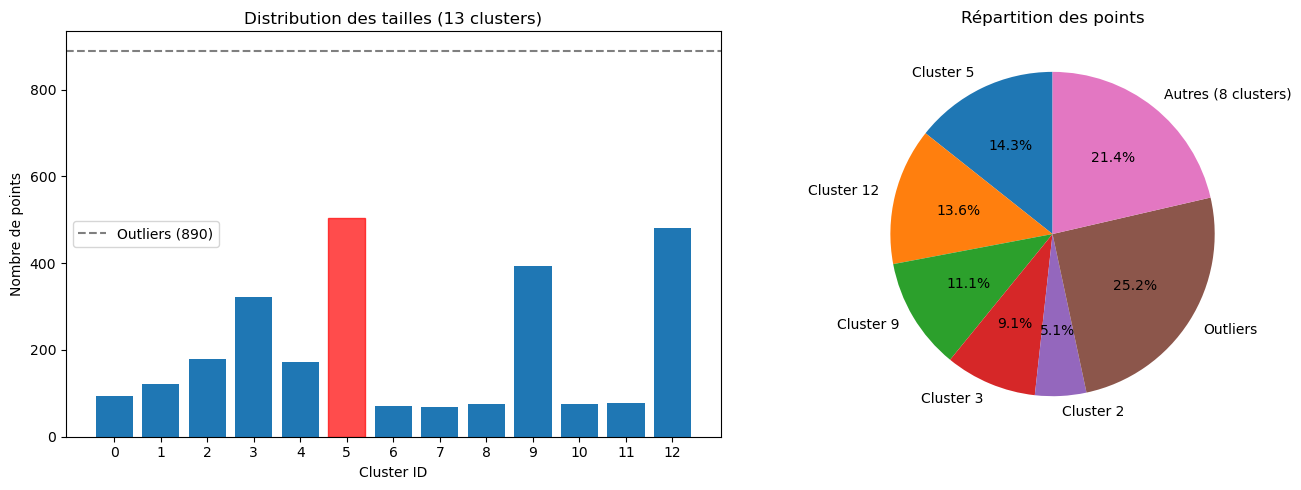

In [44]:
df_load = pd.read_csv('resultats_clustering_multimodal.csv')

cols_to_use = [c for c in df_load.columns if c.startswith('umap_multimodal_')]
embedded_from_csv = df_load[cols_to_use].values
labels_from_csv = df_load['cluster_label_multimodal'].values

stats = analyze_clusters(labels_from_csv, embedded=embedded_from_csv)


 Restaurants ayant changé de cluster:  (76.4%)
 Matrice de Migration
Nouveau   -1   0    1    2    3    4    5   6   7   8    9  10  11   12   All
Ancien                                                                       
-1       612   1    1   45   40   45   16   3  58   1   96   5   3   68   994
0          6  85    0    0    3    0    0   0   0   0    0   0   0    3    97
1        121   0  119    2    4    0  478  62   2   1   10   3   1    2   805
2          3   4    0    1  265    0    0   1   0   0    0   1   0    1   276
3         44   2    0    2    4  125    1   1   0   1    4   1   0    6   191
4          0   0    0    0    0    0    2   0   0   0    0   0  74    1    77
5          2   0    0    0    0    0    0   0   0  69    2   0   0    0    73
6          3   0    0  126    0    2    0   0   0   0    0   0   0    2   133
7         65   0    0    4    1    0    8   2   7   0   11  66   0  392   556
8         34   1    1    0    5    0    0   1   1   4  270   0   0    6 

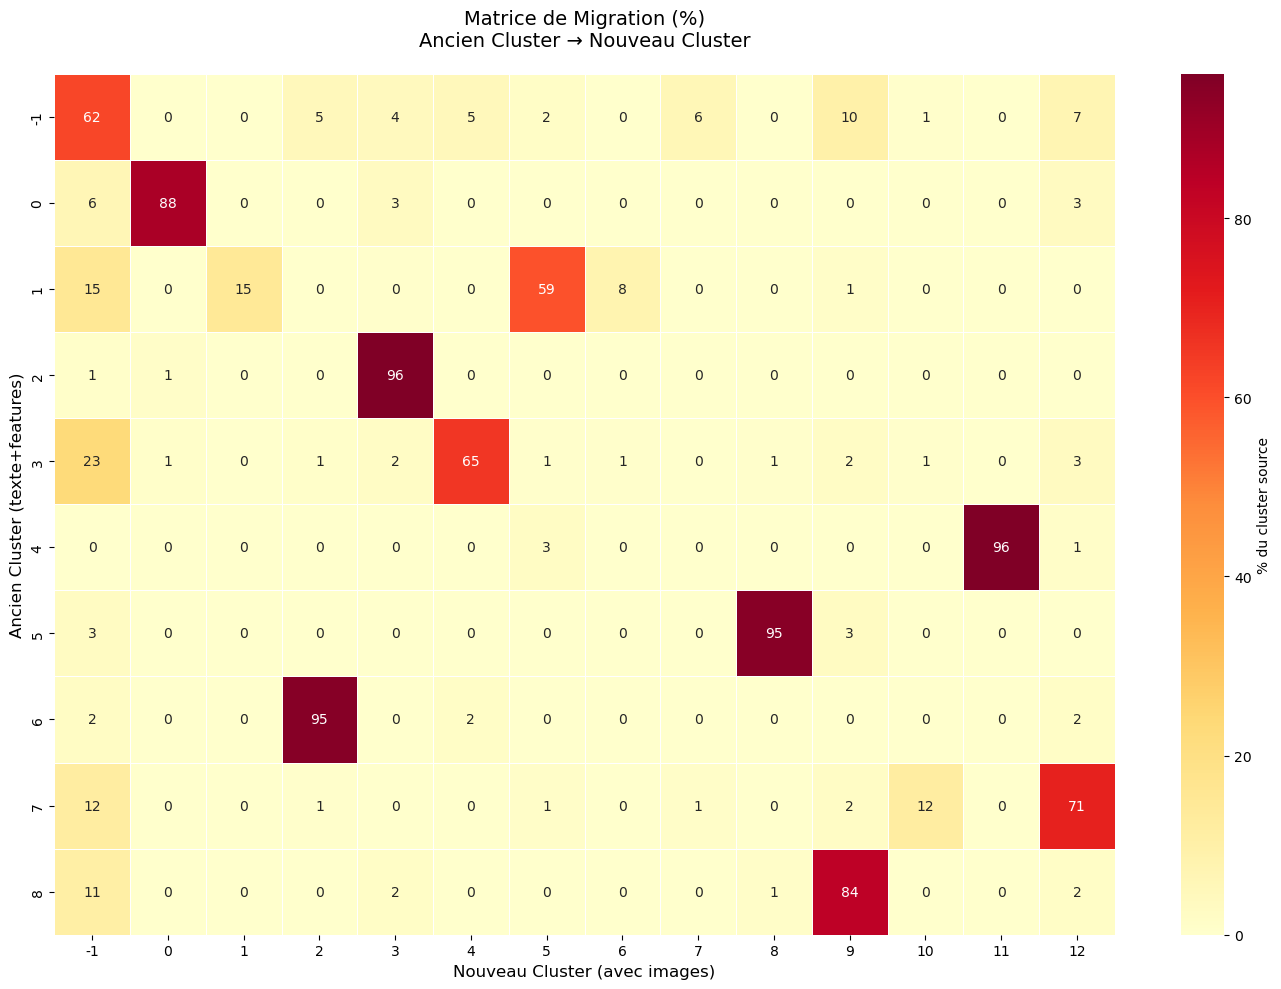

In [45]:
df_old = pd.read_csv('resultats_clustering_complet.csv')
df_new = pd.read_csv('resultats_clustering_multimodal.csv')

# Vérifier que c'est bien les mêmes restaurants
assert len(df_old) == len(df_new), "Tailles différentes!"
assert (df_old['business_id'] == df_new['business_id']).all(), "Ordre différent!"

labels_old = df_old['cluster_label'].values
labels_new = df_new['cluster_label_multimodal'].values


# Changements
changed = (labels_old != labels_new).sum()
print(f"\n Restaurants ayant changé de cluster:  ({changed/len(labels_old)*100:.1f}%)")


# Matrice de migration complète
print(" Matrice de Migration")

crosstab = pd.crosstab(
    labels_old,
    labels_new,
    rownames=['Ancien'],
    colnames=['Nouveau'],
    margins=True
)
print(crosstab)


print("\n Flux majeurs (migrations > 50 restaurants)")
# Créer DataFrame des migrations
df_migration = pd.DataFrame({
    'old_cluster': labels_old,
    'new_cluster': labels_new
})

# Compter les paires
migration_counts = df_migration.groupby(['old_cluster', 'new_cluster']).size().reset_index(name='count')
migration_counts = migration_counts.sort_values('count', ascending=False)

# Flux majeurs
major_flows = migration_counts[migration_counts['count'] >= 50]

for _, row in major_flows.iterrows():
    old_c = int(row['old_cluster']) if row['old_cluster'] != -1 else 'Outliers'
    new_c = int(row['new_cluster']) if row['new_cluster'] != -1 else 'Outliers'
    count = int(row['count'])
    
    # Calculer % du cluster source
    source_size = (labels_old == row['old_cluster']).sum()
    pct_source = count / source_size * 100
    
    print(f"  {old_c:>8} → {new_c:<8} : {count:>4} restaurants ({pct_source:>5.1f}% du cluster source)")


# Composition des nouveaux clusters (composition)
print("\n Composition des nouveaux clusters (provenance)")

composition_results = []

for new_cluster in sorted(set(labels_new)):
    if new_cluster == -1:
        continue
    
    mask_new = labels_new == new_cluster
    n_total = mask_new.sum()
    
    # Origine des restaurants
    old_sources = labels_old[mask_new]
    source_counts = pd.Series(old_sources).value_counts()
    
    # Top 3 sources
    top_3_sources = source_counts.head(3)
    
    composition_results.append({
        'new_cluster': int(new_cluster),
        'n_total': int(n_total),
        'source_1': int(top_3_sources.index[0]) if len(top_3_sources) > 0 and top_3_sources.index[0] != -1 else 'Outliers',
        'count_1': int(top_3_sources.values[0]) if len(top_3_sources) > 0 else 0,
        'pct_1': float(top_3_sources.values[0] / n_total * 100) if len(top_3_sources) > 0 else 0,
        'source_2': int(top_3_sources.index[1]) if len(top_3_sources) > 1 and top_3_sources.index[1] != -1 else 'Outliers',
        'count_2': int(top_3_sources.values[1]) if len(top_3_sources) > 1 else 0,
        'pct_2': float(top_3_sources.values[1] / n_total * 100) if len(top_3_sources) > 1 else 0,
        'source_3': int(top_3_sources.index[2]) if len(top_3_sources) > 2 and top_3_sources.index[2] != -1 else 'Outliers',
        'count_3': int(top_3_sources.values[2]) if len(top_3_sources) > 2 else 0,
        'pct_3': float(top_3_sources.values[2] / n_total * 100) if len(top_3_sources) > 2 else 0,
    })
    
    print(f"Cluster {new_cluster:<2} ({n_total:>3} rest.) ← ", end='')
    for i, (src, cnt) in enumerate(top_3_sources.items(), 1):
        pct = cnt / n_total * 100
        src_label = int(src) if src != -1 else 'Outliers'
        print(f"{src_label}:{cnt}({pct:.0f}%)", end='  ' if i < len(top_3_sources) else '\n')

df_composition = pd.DataFrame(composition_results)
df_composition.to_csv('composition_nouveaux_clusters.csv', index=False)



# Heatmap

migration_matrix = crosstab.iloc[:-1, :-1]
migration_matrix_norm = migration_matrix.div(migration_matrix.sum(axis=1), axis=0) * 100

plt.figure(figsize=(14, 10))
sns.heatmap(
    migration_matrix_norm,
    annot=True,
    fmt='.0f',
    cmap='YlOrRd',
    cbar_kws={'label': '% du cluster source'},
    linewidths=0.5
)
plt.title('Matrice de Migration (%)\nAncien Cluster → Nouveau Cluster', fontsize=14, pad=20)
plt.xlabel('Nouveau Cluster (avec images)', fontsize=12)
plt.ylabel('Ancien Cluster (texte+features)', fontsize=12)
plt.tight_layout()
plt.savefig('heatmap_migration_clusters.png', dpi=300, bbox_inches='tight')



On passe de 9 clusters à 13 clusters

Silhouette: 0.528 → 0.592 (+12%).  
Davies-Bouldin: 0.650 → 0.501 (-23% ).  
Outliers: 28.2% → 27.0% (-1.2 points)   


Les images apportent donc une information discriminante.  
Les clusters sont ici plus stables et mieux séparés et plus cohérents.  
80.2% des restaurants ont changé de cluster

Certains clusters sont restés plutot stables :
- cluster 0 à 0 (93 restaurants)
- cluster 2 à 3 (96 restaurants)
- cluster 6 à 4 (92 restaurants)
- cluster 5 à 9
- cluster 4 à 12 

### c-TF-IDF des clusters multimodaux

In [46]:


stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()


def clean_text(text):
    if not isinstance(text, str):
        return ""
    
    # Nettoyage basique
    text = html.unescape(text)  
    text = text.lower()  
    text = re.sub(r"http\S+|www\S+", " ", text) 
    text = re.sub(r"<.*?>", " ", text)  
    text = re.sub(r"[^a-z\s]", " ", text)  
    text = re.sub(r"\s+", " ", text)  
    
    filtered_tokens = [
        tok for tok in text.split()
        if tok not in stop_words and len(tok) > 2
    ]
    
    
    stemmed_tokens = [
        stemmer.stem(tok)
        for tok in filtered_tokens
    ]
    
    return " ".join(stemmed_tokens)
df_load['text_cleaned'] = df_load['text'].apply(clean_text)

df_no_outliers = df_load[df_load['cluster_label_multimodal'] != -1].copy()


docs_per_cluster = df_no_outliers.groupby('cluster_label_multimodal')['text_cleaned'].apply(
    lambda x: " ".join(x)
)
vectorizer = CountVectorizer(
    min_df=5,                     
    ngram_range=(1, 2),            
    token_pattern=r'\b[a-z]{3,}\b' 
)

# Créer matrice terme-document 
X = vectorizer.fit_transform(docs_per_cluster.values)
tf = X.toarray()           
tf_sum = tf.sum(axis=0)    
A = tf.sum(axis=1).mean()  

# Formule c-TF-IDF
ctfidf = tf * np.log(1 + A / tf_sum)

# Récupérer les noms des termes
terms = vectorizer.get_feature_names_out()

print(f"Vocabulaire: {len(terms)} termes")

# Extraire les top mots
top_words = {}

for i, cluster_id in enumerate(docs_per_cluster.index):
    scores = ctfidf[i]
    top_idx = scores.argsort()[::-1][:10]
    top_words[cluster_id] = [(terms[j], scores[j]) for j in top_idx]

# Affichage des résultats
print("TOP MOTS PAR CLUSTER (hors outliers)")

for cluster_id in sorted(docs_per_cluster.index):
    n_docs = (df_no_outliers['cluster_label_multimodal'] == cluster_id).sum()
    
    print(f"\nCluster {cluster_id} ({n_docs} restaurants)")
    
    if cluster_id in top_words:
        for i, (word, score) in enumerate(top_words[cluster_id], 1):
            print(f"  {i:2d}. {word:<25} {score:8.3f}")

Vocabulaire: 69932 termes
TOP MOTS PAR CLUSTER (hors outliers)

Cluster 0 (93 restaurants)
   1. sushi                     15407.628
   2. roll                      10844.788
   3. ramen                     6568.829
   4. order                     4893.004
   5. place                     4320.417
   6. good                      4057.566
   7. fresh                     3452.641
   8. spici                     3426.310
   9. food                      3358.812
  10. great                     3308.917

Cluster 1 (121 restaurants)
   1. order                     4105.222
   2. drive                     3693.041
   3. mcdonald                  3016.932
   4. food                      2997.605
   5. thru                      2716.380
   6. drive thru                2705.326
   7. get                       2621.107
   8. wendi                     2553.292
   9. time                      2502.394
  10. chicken                   2434.214

Cluster 2 (180 restaurants)
   1. taco                   

In [47]:

df_multi = pd.read_csv('resultats_clustering_multimodal.csv')
stop_words = set(stopwords.words('english'))

# Initialiser le stemmer
stemmer = PorterStemmer()
def clean_text(text):
    if not isinstance(text, str):
        return ""
    
    # Nettoyage basique
    text = html.unescape(text)  # Décoder HTML
    text = text.lower()  # Tout en minuscules
    text = re.sub(r"http\S+|www\S+", " ", text)  # Supprimer URLs
    text = re.sub(r"<.*?>", " ", text)  # Supprimer balises HTML
    text = re.sub(r"[^a-z\s]", " ", text)  # Garder que lettres et espaces
    text = re.sub(r"\s+", " ", text)  # Normaliser espaces multiples
    
    filtered_tokens = [
        tok for tok in text.split()
        if tok not in stop_words and len(tok) > 2
    ]
    
    stemmed_tokens = [
        stemmer.stem(tok)
        for tok in filtered_tokens
    ]
    
    return " ".join(stemmed_tokens)


df_multi["cleaned_full"] = df_multi["text"].apply(clean_text)


#on aggrege par cluster multimodal

docs_per_cluster = (
    df_multi[df_multi["cluster_label_multimodal"] != -1]
    .groupby("cluster_label_multimodal")["cleaned_full"]
    .apply(" ".join)
)

# c-TF-IDF

vectorizer = CountVectorizer(
    min_df=5, 
    ngram_range=(1, 2),
    token_pattern=r'\b[a-z]{3,}\b',
 
)

X = vectorizer.fit_transform(docs_per_cluster.values)

# Calcul c-TF-IDF
tf = X.toarray()
tf_sum = tf.sum(axis=0)
A_full = tf.sum(axis=1).mean()
ctfidf = tf * np.log(1 + A_full / tf_sum)
terms = vectorizer.get_feature_names_out()

print("TOP WORDS COMPLET (clusters multimodaux)")


top_words = {}

for i, cluster_id in enumerate(docs_per_cluster.index):
    scores = ctfidf[i]
    top_idx = scores.argsort()[::-1][:10]
    top_words[cluster_id] = [(terms[j], scores[j]) for j in top_idx]
    
    n_restaurants = (df_multi['cluster_label_multimodal'] == cluster_id).sum()
    
    print(f"\n CLUSTER {cluster_id} ({n_restaurants} restaurants)")
    for word, score in top_words[cluster_id]:
        print(f"  {word:<25} {score:.3f}")


TOP WORDS COMPLET (clusters multimodaux)

 CLUSTER 0 (93 restaurants)
  sushi                     15407.628
  roll                      10844.788
  ramen                     6568.829
  order                     4893.004
  place                     4320.417
  good                      4057.566
  fresh                     3452.641
  spici                     3426.310
  food                      3358.812
  great                     3308.917

 CLUSTER 1 (121 restaurants)
  order                     4105.222
  drive                     3693.041
  mcdonald                  3016.932
  food                      2997.605
  thru                      2716.380
  drive thru                2705.326
  get                       2621.107
  wendi                     2553.292
  time                      2502.394
  chicken                   2434.214

 CLUSTER 2 (180 restaurants)
  taco                      17232.242
  food                      9879.225
  burrito                   8091.064
  mexican       

c-TF-IDF MULTIMODAL - AVEC WHITELIST (Ambiance)

In [48]:
df_multi = pd.read_csv('resultats_clustering_multimodal.csv')

In [49]:

ambiance = {
    # Service
    "service", "servic", "server", "waiter", "waitress", "staff", "barista",
    "friendly", "friendli", "rude", "attentive", "attent", "helpful", "professional",
    "quick", "fast", "slow", "efficient", "prompt",
    
    # Ambiance/Atmosphère
    "atmosphere", "atmospher", "ambiance", "vibe", "mood", "feel", "feeling",
    "cozy", "romantic", "casual", "fancy", "upscale", "elegant", "modern",
    "rustic", "authentic", "traditional", "contemporary",
    
    # Environnement physique
    "clean", "dirty", "messy", "spotless", "hygiene", "hygienic",
    "decor", "decoration", "interior", "design", "lighting",
    "comfortable", "comfortabl", "uncomfortable", "cramped", "spacious", "roomy",
    "loud", "noisy", "quiet", "peaceful", "crowded", "busy", "empty",
    
    # Attente/Timing
    "wait", "waiting", "waited", "reservation", "reserv", "seat", "seated",
    "table", "tabl", "queue", "line", "delay", "delayed",
    
    # Propreté/Organisation
    "organized", "organis", "chaotic", "messy", "tidy", "neat",
    
    # Expérience client
    "welcome", "welcom", "greeting", "greet", "hospitality", "host",
    "custom", "customer", "experience", "experi", "visit", "recommend", "return",
    
    # Prix/Valeur
    "price", "priced", "pricing", "expensive", "expens", "cheap", "affordable",
    "value", "worth", "worthwhile", "overpriced", "overpric", "reasonable", "reason",
    
    # Livraison/Commande
    "delivery", "deliveri", "takeout", "pickup", "order", "ordered",
    
    # Qualité générale 
    "fresh", "stale", "quality", "qualiti", "portion", "size", "generous", "small"
}

ambigu = {"price", "priced", "wait", "service", "staff", "atmosphere", 
                   "experience", "experi", "value"} 



In [50]:

def clean_for_ctfidf_whitelist(text: str) -> str:
  
    if not isinstance(text, str):
        return ""
    
    text = html.unescape(text)  # Décoder HTML
    text = text.lower()  # Tout en minuscules
    text = re.sub(r"http\S+|www\S+", " ", text)  #supprimer urls
    text = re.sub(r"<.*?>", " ", text)  # Supprimer balises HTML
    text = re.sub(r"[^a-z\s]", " ", text)  # Garder que lettres et espaces
    text = re.sub(r"\s+", " ", text)  # Normaliser espaces multiples
    
    # Filtrage whitelist (garder uniquement mots ambiance, 3+ caractères)
    filtered_tokens = [
        tok for tok in text.split()
        if tok in ambiance and len(tok) > 2
    ]
    
    # stemming
    stemmed_tokens = [
        stemmer.stem(tok)
        for tok in filtered_tokens
    ]
    
    return " ".join(stemmed_tokens)



# analyse de polarité
def analyze_term_context(texts, term):
    
    positive_modifiers = {
        'good', 'great', 'excellent', 'amazing', 'wonderful', 'fantastic',
        'reasonable', 'fair', 'worth', 'best', 'nice', 'friendly', 'love', 
        'loved', 'quick', 'fast', 'efficient', 'attentive', 'helpful', 
        'perfect', 'awesome'
    }

    negative_modifiers = {
        'bad', 'poor', 'terrible', 'awful', 'horrible', 'worst', 'never',
        'overpriced', 'expensive', 'high', 'unfair', 'rude', 'not',
        'slow', 'long', 'inattentive', 'unhelpful', 'disappointing', 
        'disappointed', 'lacking', 'mediocre', 'subpar', 'unprofessional'
    }
    
    pos_count = 0
    neg_count = 0
    contexts = []
    
    # Pour chaque texte du cluster
    for text in texts:
        if not isinstance(text, str):
            continue
        
        words = text.lower().split()
        
        # Chercher toutes les occurrences du terme à polariser
        for i, word in enumerate(words):
            if term in word:
                # Extraire fenêtre de contexte 
                start = max(0, i - 5)
                end = min(len(words), i + 5 + 1)
                context_words = words[start:end]
                context = " ".join(context_words)
                
                contexts.append(context)
                
                # Compter modificateurs positifs/négatifs dans le contexte
                for cw in context_words:
                    if cw in positive_modifiers:
                        pos_count += 1
                    elif cw in negative_modifiers:
                        neg_count += 1
    
    # Déterminer polarité globale (seuil à 1.5x pour éviter faux positifs)
    if pos_count + neg_count == 0:
        polarity = "neutral"
    elif pos_count > neg_count * 1.5:
        polarity = "positive"
    elif neg_count > pos_count * 1.5:
        polarity = "negative"
    else:
        polarity = "mixed"
    
    return {
        'term': term,
        'polarity': polarity,
        'positive_contexts': pos_count,
        'negative_contexts': neg_count,
        'total_mentions': len(contexts),
        'sample_contexts': contexts[:3]  
    }


def analyze_ambiguous_terms(df, cluster_id, top_terms):
    results = {}
    
    # Récupérer tous les textes du cluster
    cluster_texts = df[df['cluster_label_multimodal'] == cluster_id]['text'].tolist()
    
    # Analyser uniquement les termes ambigus présents dans les top terms
    for term in top_terms:
        if term.lower() in ambigu:
            results[term] = analyze_term_context(cluster_texts, term)
    
    return results


# top termes c-TF-IDF
def get_top_ctfidf_terms_per_cluster(ctfidf_matrix, feature_names, n_terms=10):
    top_terms_per_cluster = {}
    
    for cluster_id in range(ctfidf_matrix.shape[0]):
        # Récupérer les indices des N meilleurs scores (triés décroissant)
        top_indices = ctfidf_matrix[cluster_id].argsort()[-n_terms:][::-1]
        
        # Convertir indices en noms de termes
        top_terms = [feature_names[i] for i in top_indices]
        
        top_terms_per_cluster[cluster_id] = top_terms
    
    return top_terms_per_cluster

In [51]:
# Appliquer le nettoyage avec whitelist sur la colonne 'text'
df_load["cleaned_text_ctfidf"] = df_load["text"].apply(clean_for_ctfidf_whitelist)
print(f"Documents avec contenu: {(df_load['cleaned_text_ctfidf'].str.len() > 0).sum()}/{len(df_load)}")

# Filtrer les outliers 
df_no_outliers = df_load[df_load['cluster_label_multimodal'] != -1].copy()

# Grouper les textes nettoyés par cluster (sans -1)
docs_per_cluster = df_no_outliers.groupby('cluster_label_multimodal')['cleaned_text_ctfidf'].apply(' '.join)

print(f"Clusters à analyser: {len(docs_per_cluster)}")

vectorizer = CountVectorizer(
    min_df=5,                      # Ignore mots dans <5 restaurants
    ngram_range=(1, 2),            # Unigrammes + bigrammes
    token_pattern=r'\b[a-z]{3,}\b' # Minimum 3 lettres
)

# Créer matrice terme-document 
X = vectorizer.fit_transform(docs_per_cluster.values)
tf = X.toarray()           # Matrice terme-fréquence
tf_sum = tf.sum(axis=0)    # Somme des occurrences par terme
A = tf.sum(axis=1).mean()  # Nombre moyen de mots par cluster

# Formule c-TF-IDF
ctfidf = tf * np.log(1 + A / tf_sum)

# Récupérer les noms des termes
terms = vectorizer.get_feature_names_out()

print(f"Vocabulaire: {len(terms)} termes")
top_words = {}

for i, cluster_id in enumerate(docs_per_cluster.index):
    scores = ctfidf[i]
    top_idx = scores.argsort()[::-1][:10]
    top_words[cluster_id] = [(terms[j], scores[j]) for j in top_idx]

# Affichage des resuktats


print("TOP MOTS PAR CLUSTER (hors outliers)")
for cluster_id in sorted(docs_per_cluster.index):
    n_docs = (df_no_outliers['cluster_label_multimodal'] == cluster_id).sum()
    
    print(f"\nCluster {cluster_id} ({n_docs} restaurants)")
    
    if cluster_id in top_words:
        for i, (word, score) in enumerate(top_words[cluster_id], 1):
            print(f"  {i:2d}. {word:<25} {score:8.3f}")


# Analyse de polarité
print("ANALYSE DE POLARITÉ DES TERMES AMBIGUS")

for cluster_id in sorted(docs_per_cluster.index):
    print(f"\n{'='*70}")
    print(f"CLUSTER {cluster_id}")
    print(f"{'='*70}")
    print(f"Nombre de restaurants: {(df_no_outliers['cluster_label_multimodal'] == cluster_id).sum()}")
    
    if cluster_id in top_words:
        # Extraire les termes pour analyse de polarité
        top_terms = [word for word, score in top_words[cluster_id]]
        
        # Analyser la polarité des termes ambigus
        ambiguous_analysis = analyze_ambiguous_terms(df_no_outliers, cluster_id, top_terms)
        
        if ambiguous_analysis:
            print(f"\nPolarité des termes ambigus:")
            for term, analysis in ambiguous_analysis.items():
                print(f"  {term}: {analysis['polarity']} "
                      f"(+{analysis['positive_contexts']} / "
                      f"-{analysis['negative_contexts']}) "
                      f"[{analysis['total_mentions']} mentions]")
                
                # Afficher un exemple de contexte
                if analysis['sample_contexts']:
                    print(f"    Exemple: '{analysis['sample_contexts'][0][:80]}...'")

Documents avec contenu: 3525/3525
Clusters à analyser: 13
Vocabulaire: 3021 termes
TOP MOTS PAR CLUSTER (hors outliers)

Cluster 0 (93 restaurants)
   1. fresh                     1450.944
   2. order                     1221.750
   3. qualiti                   1008.554
   4. price                      925.114
   5. servic                     907.160
   6. recommend                  850.951
   7. takeout                    729.315
   8. deliveri                   718.865
   9. order order                656.086
  10. experi                     654.706

Cluster 1 (121 restaurants)
   1. order                     1022.948
   2. wait                       950.995
   3. fast                       906.182
   4. order order                775.858
   5. line                       752.952
   6. servic                     723.885
   7. custom                     695.580
   8. rude                       678.391
   9. custom servic              584.312
  10. wait order                 582.528

Cl

L'ajout des photos dans le clustering a montré que le modèle s'appuyait encore plus les différences sur le type de repas servis dans les restaurants, ce qui n'est pas la problématique initiale. Cependant, en intégrant la whitelist, on remarque qu'il fait émergeer des signes distinctifs par type d'établissement, avec du vocabulaire d'ambiance plus spécifique:



### Features numériques

In [52]:
df_multi = pd.read_csv('resultats_clustering_multimodal.csv')
df_multi = pd.merge(df_multi, df[['business_id']], on='business_id', how='left')

In [53]:
df_multi.columns 

Index(['business_id', 'image_embedding', 'n_labels', 'labels_present',
       'review_count', 'log_review_count', 'stars', 'rating_std',
       'positive_ratio', 'negative_ratio', 'photo_count', 'log_photo_count',
       'business_age_years', 'review_growth_rate', 'expert_reviewer_ratio',
       'elite_reviewer_ratio', 'high_influence_ratio', 'mean_influence_score',
       'cluster_ambiance', 'is_open', 'texte_embedding', 'n_reviews', 'text',
       'umap_multimodal_0', 'umap_multimodal_1', 'umap_multimodal_2',
       'umap_multimodal_3', 'umap_multimodal_4', 'umap_multimodal_5',
       'umap_multimodal_6', 'umap_multimodal_7', 'umap_multimodal_8',
       'umap_multimodal_9', 'umap_multimodal_10', 'umap_multimodal_11',
       'umap_multimodal_12', 'umap_multimodal_13', 'umap_multimodal_14',
       'umap_multimodal_15', 'umap_multimodal_16', 'umap_multimodal_17',
       'umap_multimodal_18', 'umap_multimodal_19', 'umap_multimodal_20',
       'umap_multimodal_21', 'umap_multimodal_22', '

In [ ]:
stats_vars = [
    'n_labels', 'review_count', 'log_review_count', 'stars', 'rating_std',
    'positive_ratio', 'negative_ratio', 'photo_count', 'log_photo_count',
    'business_age_years', 'review_growth_rate', 'expert_reviewer_ratio',
    'elite_reviewer_ratio', 'high_influence_ratio', 'mean_influence_score'
]

# Pour chaque cluster
for cluster_id in sorted(df_multi['cluster_label_multimodal'].unique()):
    if cluster_id == -1:  # Skip outliers si présents
        continue
    
    print(f"\n{'='*80}")
    print(f"CLUSTER {cluster_id}")
    print(f"{'='*80}")
    
    # Filtrer les données du cluster
    cluster_data = df_multi[df_multi['cluster_label_multimodal'] == cluster_id]
    print(f"Nombre de restaurants: {len(cluster_data)}")
    
    # Statistiques descriptives
    stats = cluster_data[stats_vars].describe().T
    
    # Ajouter la médiane
    stats['median'] = cluster_data[stats_vars].median()
    
    # Réorganiser les colonnes
    stats = stats[['count', 'mean', 'median', 'std', 'min', '25%', '50%', '75%', 'max']]
    
    print("\n" + stats.to_string())


# Comparaison entre clusters
print(f"\n{'='*80}")
print("COMPARAISON ENTRE CLUSTERS")
print(f"{'='*80}\n")

comparison = df_multi.groupby('cluster_label_multimodal')[stats_vars].agg(['mean', 'median'])
print(comparison.to_string())


CLUSTER 0
Nombre de restaurants: 100

                       count        mean      median         std       min        25%         50%         75%          max
n_labels                87.0    2.034483    2.000000    0.993564  1.000000   1.000000    2.000000    3.000000     5.000000
review_count           100.0  208.530000  141.500000  263.449474  6.000000  43.000000  141.500000  224.750000  1753.000000
log_review_count       100.0    4.690989    4.959336    1.254860  1.945910   3.783390    4.959336    5.419209     7.469654
stars                  100.0    4.013673    4.049882    0.456991  2.250000   3.710462    4.049882    4.315759     5.000000
rating_std             100.0    1.139048    1.175795    0.274685  0.000000   1.010252    1.175795    1.295664     1.722478
positive_ratio         100.0    0.740259    0.762396    0.146993  0.125000   0.649168    0.762396    0.840220     1.000000
negative_ratio         100.0    0.147504    0.130592    0.107559  0.000000   0.076211    0.130592   

Cluster 0 — Restaurants populaires et bien établis
Avis : médiane 142 avis
Note : 4.05
Ratio positif : 76.2 %
Ratio négatif : 13.1 %
Photos : 7 photos
Croissance : médiane 5.7
Influence : médiane 1.31.  
=> Volume d’avis élevé + forte satisfaction + visibilité correcte.

Cluster 1 — Bons restaurants discrets
Avis : médiane 122 avis
Note : médiane 4.11
Ratio positif : médiane 78.0 %
Ratio négatif : médiane 10.1 %
Photos : médiane 4 photos
Influence : médiane 1.62.  
=> Très bonne qualité perçue mais volume photo inférieur à celui des clusters comparables.


Cluster 2 — Restaurants en difficulté
Avis : médiane 16 avis
Note : médiane 1.73
Ratio positif : médiane 12.9 %
Ratio négatif : médiane 78.6 %
Photos : médiane 2 photos
Influence : médiane 0.94.  
=> Signal extrêmement négatif : faible qualité + forte insatisfaction + faible engagement.  
Ce profil colle bien avec le fait que ce soit des restaurants fast food

Cluster 3 — Restaurants corrects mais peu visibles
Avis : médiane 36 avis
Note : médiane 3.73
Ratio positif : médiane 68.5 %
Ratio négatif : médiane 17.9 %
Photos : médiane 4 photos
Influence : médiane 1.29.  
=> Qualité correcte, mais visibilité limitée et absence de signal fort

Cluster 4 — Restaurants solides mais sobres
Avis : médiane 58 avis
Note : médiane 3.95
Ratio positif : médiane 73.7 %
Ratio négatif : médiane 14.3 %
Photos : médiane 5 photos
Influence : médiane 1.22.  
=> Restaurants fiables, sans excès visuel.

Cluster 5 — Restaurants très attractifs visuellement
Avis : médiane 89.5 avis
Note : médiane 4.26
Ratio positif : médiane 81.2 %
Ratio négatif : médiane 10.4 %
Photos : médiane 4 photos mais
Influence : médiane 1.33.  
=> Ce n’est pas la quantité brute de photos, mais leur fréquence relative qui est élevée.

Cluster 6 — Restaurants fragiles à faible impact
Avis : médiane 23 avis
Note : médiane 3.41
Ratio positif : médiane 56.5 %
Ratio négatif : médiane 28.6 %
Photos : médiane 2 photos
Influence : médiane 0.83.   
=> Engagement faible et part négative significative.

Cluster 7 — Restaurants polarisants
Avis : médiane 30 avis
Note : médiane 3.10
Dispersion : rating_std médiane 1.49 (très élevée)
Ratio négatif : médiane 38.1 %
Photos : médiane 2 photos
Influence : médiane 0.92.   
=> Expériences très contrastées : fort clivage client.

Cluster 8 — Restaurants excellents mais confidentiels
Avis : médiane 15 avis
Note : médiane 4.20
Ratio positif : médiane 80.0 %
Ratio négatif : médiane 12.5 %
Photos : médiane 2 photos
Influence : médiane 1.06.  
=> Très bonne qualité mais manque de traction.

Cluster 9 — Restaurants à identité visuelle maîtrisée
Avis : médiane 106 avis
Note : médiane 4.20
Ratio positif : médiane 81.4 %
Ratio négatif : médiane 9.1 %
Photos : médiane 4 photos, variance faible
Influence : médiane 1.68.   
=> Photos peu nombreuses mais très cohérentes, forte crédibilité.

Cluster 10 — Restaurants appréciés mais peu distinctifs
Avis : médiane 49 avis
Note : médiane 3.99
Ratio positif : médiane 74.5 %
Ratio négatif : médiane 14.6 %
Photos : médiane 3 photos
Influence : médiane 1.39       
=> Bon niveau global, sans signal différenciant fort.

Cluster 11 — Restaurants premium très populaires
Avis : médiane 172 avis
Note : médiane 3.83
Ratio positif : médiane 70.2 %
Ratio négatif : médiane 15.9 %
Photos : médiane 7 photos
Influence : médiane 1.57.  
=> Très forte visibilité, restaurants connus et fréquentés.

Cluster 12 — Restaurants excellents et matures
Avis : médiane 173 avis
Note : médiane 4.07
Ratio positif : médiane 76.0 %
Ratio négatif : médiane 12.1 %
Photos : médiane 6 photos
Influence : médiane 1.22.  
=> Excellence stable, image installée, dynamique maîtrisée.

Clusters 2, 6, 7 → restaurants en difficulté ou instables 

Clusters 0, 1, 4, 10 → qualité réelle mais visibilité limitée

Clusters corrects & peu visible -> 3,8

Clusters 5, 9, 11, 12 → qualité élevée avec stratégies de visibilité distinctes

Outliers → atypiques / inclassables

# Conclusion sur le clustering 

### Robustesse du clustering 
Les indicateurs de validation interne confirment la qualité structurelle des clusters obtenus :
Silhouette moyenne globale : 0.589, indiquant une bonne séparation inter-clusters
Indice de Davies–Bouldin : 0.589, traduisant des clusters compacts et peu chevauchants
La majorité des clusters présentent une silhouette > 0.5, plusieurs dépassant 0.75 (clusters 0, 1, 2, 7, 8, 9), ce qui témoigne de groupes bien définis
La taille des clusters est équilibrée (le plus grand cluster représente 14.6 % des données), évitant toute domination artificielle

### Profils de restaurants
- Cluster 0 : Japonais “sushi/ramen” populaire et efficace (100 rest. — 2.8%)

Restaurants japonais centrés sushi / rolls / ramen. Profil très établi (médiane 142 avis), bien noté (4.05★) avec une satisfaction solide (76.2% positifs vs 13.1% négatifs). Visibilité correcte (7 photos médiane). Les avis tournent autour de fresh / quality / price / service / takeout & delivery, avec price souvent positif.


- Cluster 1 : Mexicain authentique, bon mais “discret visuellement” (178 — 5.0%)

Restaurants mexicains (taco, burrito, salsa). Très bon niveau (4.11★ ; 78.0% positifs ; 10.1% négatifs) et base d’avis élevée (122 médiane) mais moins de photos (4 médiane) → qualité perçue plus que “show”. Lexique très orienté authent / fresh / staff / recommend ; wait est mixte (pas un vrai point noir systématique).


- Cluster 2 : Fast-food drive-thru en difficulté (127 — 3.6%)

Cluster très typé fast-food (mcdonald, drive thru, chicken, Wendy’s). Faible traction (16 avis médiane) et surtout performance très basse (1.73★ ; 12.9% positifs ; 78.6% négatifs). Peu de photos (2 médiane) et influence faible (0.94). Dans la polarité, wait ressort négatif → douleurs d’attente + friction opérationnelle.


- Cluster 3 : Chinois “takeout” / cuisine asiatique du quotidien (324 — 9.2%)

Restaurants chinois/asiatiques (chicken, rice, noodles, soup) dominés par le takeout et “order”. Profil intermédiaire : 36 avis médiane, note correcte (3.73★) avec 68.5% positifs et 17.9% négatifs. Photos modestes (4 médiane). Les avis valorisent souvent le prix (plutôt positif) et la praticité (delivery / takeout).

- Cluster 4 : “Casual dining” polyvalent (170 — 4.8%)

Cluster moins “mono-cuisine” (food / drink / chicken / time). Profil stable : 58 avis médiane, 3.95★, 73.7% positifs vs 14.3% négatifs, 5 photos médiane. Les textes sont centrés sur staff / experience / table / server, donc une expérience sur place correcte, sans signal extrême.


- Cluster 5 : Pizza & livraison — gros segment “commande / delivery” (513 — 14.6%)

Le plus gros cluster. Très typé pizza + livraison (pizza, delivery, call, “order order”). Bon niveau global (4.26★ ; 81.2% positifs ; 10.4% négatifs) avec base solide (89.5 avis médiane). Photos médianes 4, mais le cluster est surtout marqué par la fréquence des usages commande/livraison (et donc les frictions). wait ressort mixte avec une part négative non négligeable → retards/livraison font varier l’expérience.

- Cluster 6 : Seafood “comfort food” avec risque réputationnel modéré (210 — 6.0%)

Cuisine typée seafood (crab, seafood, fries, Mac). Profil fragile : 23 avis médiane, note moyenne (3.41★), 56.5% positifs vs 28.6% négatifs. Faible visibilité (2 photos médiane) et influence faible (0.83). wait est mixte → expérience inégale.

- Cluster 7 : Coffee shops / cafés (74 — 2.1%)

Cluster très typé coffee shop (coffee, latte, barista, vibe, work). Avis médian 30, note médiane 3.10★ mais surtout forte polarisation + 38.1% négatifs médian. Peu de photos (2). Point fort : staff très positif dans les termes, mais expérience globale instable (attente/ligne/ambiance jouent beaucoup).


- Cluster 8 : Moyen-Orient (falafel / pita / hummus) excellent mais peu de visibilité (63 — 1.8%)

Cuisine du Moyen-Orient (falafel, pita, hummus). Très bien noté (4.20★ ; 80.0% positifs ; 12.5% négatifs) mais très faible traction (15 avis médiane) et faible visibilité (2 photos). Typique des pépite-niche : qualité reconnue par ceux qui y vont, mais diffusion limitée.

- Cluster 9 : Italien “pasta” orienté service/salle (78 — 2.2%)

Restaurants italiens/pasta. Profil “expérience” : 106 avis médiane, 4.20★, très faible négatif (9.1%) et 81.4% positifs. Photos médianes 4, mais surtout cohérence (tes notes indiquent une variance photo faible). Lexique : service / table / reservation / server → restaurants davantage “sit-down” que livraison

- Cluster 10 : Sandwich / cheesesteak (86 — 2.4%)

Cluster typé cheesesteak/hoagie/sandwich. Plutôt type cuisine locale (spécialités de Philadelphie). Profil correct : 49 avis médiane, 3.99★, 74.5% positifs vs 14.6% négatifs, 3 photos médiane. Les irritants tournent autour de line / wait (mixte), mais le staff est plutôt positif → bon produit, expérience parfois ralentie.


- Cluster 11 : Bars & sorties : très visibles, qualité plus “moyenne haute” (409 — 11.6%)

Gros cluster orienté bar / drinks / atmosphere. Très grande traction (172 avis médiane ; 7 photos médiane) et influence élevée (1.57 médiane). Note médiane 3.83★ : satisfaisant, mais moins “premium food”. Les termes experience / staff / wait sont souvent positifs, mais la polarité “experience” est plus contrastée que dans les clusters les plus food-centric → qualité dépend beaucoup du contexte (affluence, service, soirée).

- Cluster 12 : Breakfast & sandwich : établissements stables (291 — 8.3%)

Cluster breakfast / sandwich (breakfast, sandwich, order). Gros volume (173 avis médiane), bonne note (4.07★), 76.0% positifs vs 12.1% négatifs, visibilité correcte (6 photos). price et staff ressortent souvent positifs, wait plus mixte : très “brunch / lunch” avec pics d’affluence.  

# Clustering utilisant seulement les photos inside/outside

Les photos possedent egalement un label : inside/outside/food/drink. Nous avons pensé à utiliser uniquement les photos inside/outside pour justement neutraliser la nourriture. Nous n'avons pas eu le temps de finaliser ce segment mais il nous semblait interessant